<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recap-on-urn-estimation-with-no-hazard" data-toc-modified-id="Recap-on-urn-estimation-with-no-hazard-1">Recap on urn estimation with no hazard</a></span><ul class="toc-item"><li><span><a href="#Some-mathematical-notation" data-toc-modified-id="Some-mathematical-notation-1.1">Some mathematical notation</a></span></li><li><span><a href="#The-posterior" data-toc-modified-id="The-posterior-1.2">The posterior</a></span></li><li><span><a href="#The-log-posterior-odds" data-toc-modified-id="The-log-posterior-odds-1.3">The log-posterior odds</a></span></li></ul></li><li><span><a href="#When-there-is-a-constant-&amp;-known-hazard-rate" data-toc-modified-id="When-there-is-a-constant-&amp;-known-hazard-rate-2">When there is a constant &amp; known hazard rate</a></span></li><li><span><a href="#Results-from-Glaze-et-al.-2015" data-toc-modified-id="Results-from-Glaze-et-al.-2015-3">Results from Glaze et al. 2015</a></span></li></ul></div>

# Recap on urn estimation with no hazard

- beads are sampled sequentially from a single urn which can be of two sorts: red vs. blue

- select the urn from which you believe the beads are being sampled

## Some mathematical notation
- $U := \text{Urn } \in \{\text{red},\text{blue}  \}$
- $b_n := \text{bead number }n\text{      }   (b_n\in \{\text{red},\text{blue}  \})$
- $l_U(b) := P(b|U)=0.8 \text{   if } b=U \text{   and }0.2\text{    otherwise}$


## The posterior

In [1]:
import os, sys
sys.path.append(os.path.expanduser('~/Git/GitHub/work/Analysis_Audio2AFC_ChangePoint/Python_modules'))
import mmcomplexity as mmx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# plotting constants in notebook
mksize = 13  # marker size in plot
lw = 3.5  # line width in plot
fsize = (15, 6)  # standard figure size
tsize = (15, 9)  # taller figure
fsquare = (9, 9)  # figure size for square display
plt.rcParams.update({'font.size': 22})

\begin{equation}\label{eq:posterior}
P(U|b_{1:n}) \propto \pi(U)\prod_{i=1}^n l_U(b_i)
\end{equation}


In [3]:
def plot_posterior_and_beads(beads, prior=(0.5, 0.5), posterior_prob='red'):
    """
    :param beads: (list) of beads observations, either 'red' or 'blue' 
    """
    # compute a few things
    num_trials = len(beads)
    x = {'blue': [], 'red': [], 'all': range(num_trials + 1)}  # holds indices for x-axis
    for i, b in enumerate(beads):
        x[b].append(i)

    y = np.array(beads)  # numpy array allows easier indexing
    
    #=== block to compute posterior ==#
    def col2side(c):
        side = 'right' if c == 'red' else 'blue'
        return side
    sided_beads = [col2side(c) for c in beads]
    stim_block = mmx.StimulusBlock(num_trials, 0, sources=['left']*num_trials, sounds=sided_beads)
    dm = mmx.KnownHazard(stim_block, sources_prior=prior)
    dm.observe()
    discrimination_decisions = list(dm.process())
    discrimination_posterior = [mmx.log_odds_to_posterior(d[0])['right'] for d in discrimination_decisions]
    discrimination_posterior.insert(0, dm.sources_prior['right'])
    posterior_to_plot = np.array(discrimination_posterior)

    if posterior_prob == 'blue':
        posterior_to_plot = 1 - posterior_to_plot
        
    #=== end of block ==#
    
    # figure setup
    fig = plt.figure(figsize=fsize)

    
    # plot posterior
    ax1 = fig.add_subplot(111)
    ax1.step(x['all'], posterior_to_plot, '-', where='post', color=posterior_prob, linewidth=lw)
    ax1.plot(x['all'], [0.5]*(num_trials+1), 'k--')
    
    ax1.set_ylabel("P('"+ posterior_prob +" urn' | beads)")
    ax1.set_ylim(0,1)
    
    # plot beads
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    
    ax2.plot(np.array(x['blue'])+1, [.5]*len(x['blue']), 'ob', markersize=mksize)
    ax2.plot(np.array(x['red'])+1, [0.5]*len(x['red']), 'or', markersize=mksize)
    
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xlabel('trial number')
    ax2.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        right=False,       # ticks along the right edge are off
        top=False,         # ticks along the top edge are off
        labelright=False)  # labels along the right edge are off
#     ax2.set_ylabel('bead')
    
    
    plt.xticks(x['all'])
    

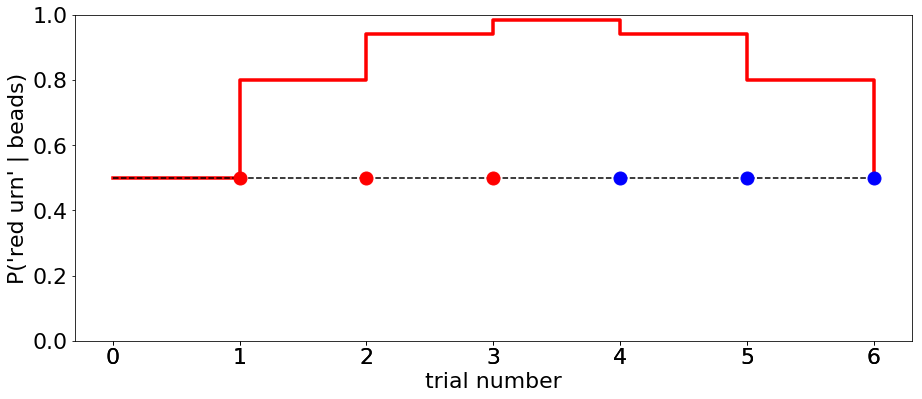

In [8]:
beads = ['red', 'red', 'red', 'blue', 'blue', 'blue']
prior_red = 0.5
plot_posterior_and_beads(beads, prior=(1-prior_red, prior_red), posterior_prob='red')

## The log-posterior odds

\begin{equation}\label{eq:logodds}
y_n:=\log \frac{P(U=\text{red} | b_{1:n} )}{P(U=\text{blue}|b_{1:n} )}
\end{equation}

\begin{equation}\label{eq:logodds2}
y_{n+1}:=y_n+\log \frac{l_\text{red}(b_{n+1})}{l_\text{blue}(b_{n+1})}
\end{equation}

In [4]:
def plot_logodds_and_beads(beads, prior=(0.5, 0.5), posterior_prob='red'):
    """
    :param beads: (list) of beads observations, either 'red' or 'blue' 
    """
    # compute a few things
    num_trials = len(beads)
    x = {'blue': [], 'red': [], 'all': range(num_trials + 1)}  # holds indices for x-axis
    for i, b in enumerate(beads):
        x[b].append(i)
        
    mksize=12            # marker size in plot
    y = np.array(beads)  # numpy array allows easier indexing
    
    #=== block to compute posterior ==#
    def col2side(c):
        side = 'right' if c == 'red' else 'blue'
        return side
    sided_beads = [col2side(c) for c in beads]
    stim_block = mmx.StimulusBlock(num_trials, 0, sources=['left']*num_trials, sounds=sided_beads)
    dm = mmx.KnownHazard(stim_block, sources_prior=prior)
    dm.observe()
    discrimination_decisions = list(dm.process())
    discrimination_posterior = [d[0] for d in discrimination_decisions]
    discrimination_posterior.insert(0, mmx.posterior_to_log_odds(dm.sources_prior))
    posterior_to_plot = np.array(discrimination_posterior)
two-sample
    if posterior_prob == 'blue':
        posterior_to_plot = - posterior_to_plot
        
    #=== end of block ==#
    
    # figure setup
    fig = plt.figure(figsize=fsize)
    plt.rcParams.update({'font.size': 22})
    
    # plot posterior
    ax1 = fig.add_subplot(111)
    ax1.step(x['all'], posterior_to_plot, '-', where='post', color=posterior_prob, linewidth=3.5)
    ax1.plot(x['all'], [0]*(num_trials+1), 'k--')
    
    ax1.set_ylabel("log posterior odds for " + posterior_prob + " urn")
    
    max_yval = np.max(np.abs(posterior_to_plot))
    yscale = max_yval + .2
    ax1.set_ylim(-yscale, yscale)
    
    # plot beads
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    
    ax2.plot(np.array(x['blue'])+1, [.5]*len(x['blue']), 'ob', markersize=mksize)
    ax2.plot(np.array(x['red'])+1, [.5]*len(x['red']), 'or', markersize=mksize)
    
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xlabel('trial number')
    ax2.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        right=False,       # ticks along the right edge are off
        top=False,         # ticks along the top edge are off
        labelright=False)  # labels along the right edge are off
#     ax2.set_ylabel('bead')
    
    
    plt.xticks(x['all'])
    

IndentationError: unexpected indent (<ipython-input-4-d08e581037c3>, line 27)

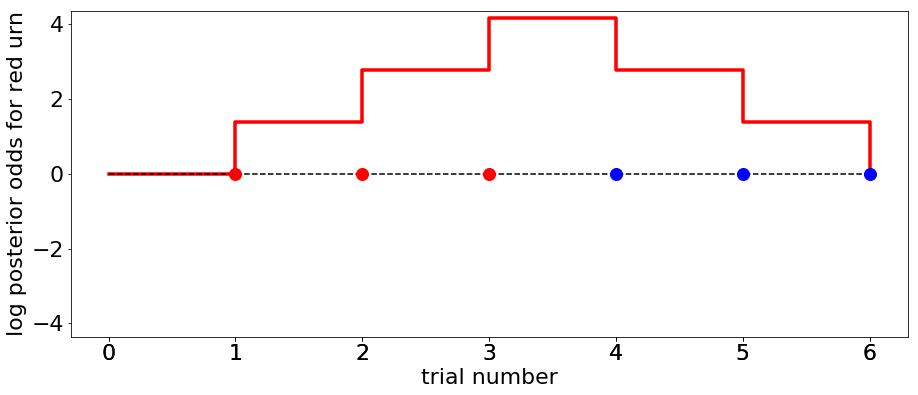

In [6]:
beads = ['red', 'red', 'red', 'blue', 'blue', 'blue']
prior_red = 0.5
plot_logodds_and_beads(beads, prior=(1-prior_red, prior_red), posterior_prob='red')

# When there is a constant & known hazard rate

\begin{equation*}
y_{n+1}:=y_n+\log \frac{l_\text{red}(b_{n+1})}{l_\text{blue}(b_{n+1})} + d(y_{n}, h)
\end{equation*}


In [5]:
def discount_old_evidence(y, hazard):
    """
    Discount evidence from last time point in optimal sequential decision making in changing environment

    hazard rate is assumed known

    Args:
        y: evidence (log posterior odds) of previous time step
        hazard: hazard rate

    Returns:
        float: positive favors 'right', negative 'left'
    """
    # todo: should I check for blow up?
    numerator = hazard * np.exp(-y) + 1 - hazard
    denominator = hazard * np.exp(y) + 1 - hazard
    return np.log(numerator / denominator)

def illustrate_discounting(h, evidence_range=(-5, 5)):
    min_h = np.min(h)
    fig = plt.figure(figsize=fsquare)
    x = np.linspace(*evidence_range)
    for h_val in h:
        line = plt.plot(x, x + discount_old_evidence(x, h_val), linewidth=lw, label='h=' + str(h_val))
        if h_val == min_h:
            plt.plot(x, np.log((1-h_val)/h_val)*np.sign(x), '--', label='upp. bound', color=line[0].get_color())
        
#     plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    
    small_x = np.linspace(-3, 3)
    plt.plot(small_x, small_x, 'k--')
    
    plt.legend(bbox_to_anchor=(1.05, .8), loc=2, borderaxespad=0.)#plt.legend(loc='lower left', framealpha=1)
    plt.xlabel('accrued evidence (log-odds)')
    plt.ylabel("discounted evidence (log-odds)")
    plt.gca().set_aspect('equal', adjustable='box')

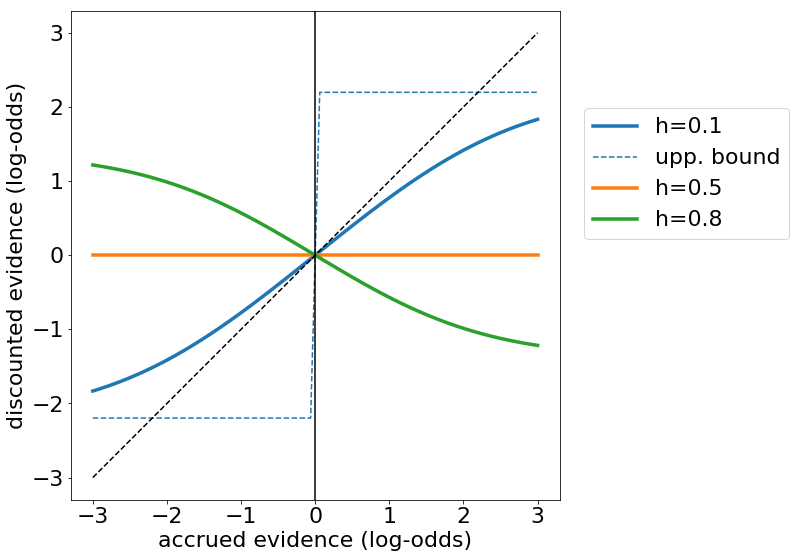

In [13]:
illustrate_discounting([0.1, .5, .8], evidence_range=(-3, 3))

In [6]:
def plot_discounting_and_beads(beads, hazards, prior=(0.5, 0.5), posterior_prob='red'):
    """
    :param beads: (list) of beads observations, either 'red' or 'blue' 
    """
    # compute a few things
    num_trials = len(beads)
    x = {'blue': [], 'red': [], 'all': range(num_trials + 1)}  # holds indices for x-axis
    for i, b in enumerate(beads):
        x[b].append(i)
        
    mksize=12            # marker size in plot
    y = np.array(beads)  # numpy array allows easier indexing
    
    #=== block to compute posterior ==#
    def col2side(c):
        side = 'right' if c == 'red' else 'blue'
        return side
    sided_beads = [col2side(c) for c in beads]
    stim_block = mmx.StimulusBlock(num_trials, 0, sources=['left']*num_trials, sounds=sided_beads)
    dm = mmx.KnownHazard(stim_block, sources_prior=prior)
    dm.observe()
    posteriors = {}
    old_max = 0
    for h in hazards:
        discrimination_decisions = list(dm.process(hazard=h))
        discrimination_posterior = [d[0] for d in discrimination_decisions]
        discrimination_posterior.insert(0, mmx.posterior_to_log_odds(dm.sources_prior))
        posterior_to_plot = np.array(discrimination_posterior)

        if posterior_prob == 'blue':
            posterior_to_plot = - posterior_to_plot
        if old_max < np.max(np.abs(posterior_to_plot)):
            max_yval = np.max(np.abs(posterior_to_plot))
            old_max = max_yval
        posteriors[h] = posterior_to_plot
        
    #=== end of block ==#
    
    # figure setup
    fig = plt.figure(figsize=tsize)
    plt.rcParams.update({'font.size': 22})
    
    # plot posterior
    ax1 = fig.add_subplot(111)
    for h in hazards:
        ax1.step(x['all'], posteriors[h], '-', where='post', linewidth=3.5, label=str(h))
    ax1.legend()
    
    ax1.plot(x['all'], [0]*(num_trials+1), 'k--')
    
    ax1.set_ylabel("log posterior odds for " + posterior_prob + " urn")
    
    
    yscale = max_yval + .3
    ax1.set_ylim(-yscale, yscale)
    
    # plot beads
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    
    ax2.plot(np.array(x['blue'])+1, [.5]*len(x['blue']), 'ob', markersize=mksize)
    ax2.plot(np.array(x['red'])+1, [.5]*len(x['red']), 'or', markersize=mksize)
    
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xlabel('trial number')
    ax2.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        right=False,       # ticks along the right edge are off
        top=False,         # ticks along the top edge are off
        labelright=False)  # labels along the right edge are off
#     ax2.set_ylabel('bead')
    
    plt.title('normative model for various hazard rates')
    plt.xticks(x['all'])
    

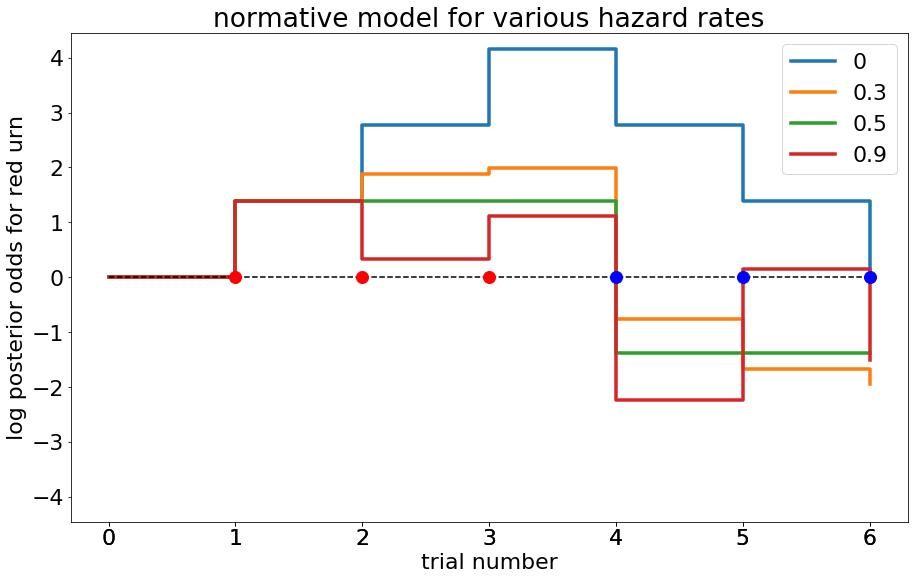

In [10]:
beads = ['red'] * 3 + ['blue'] * 3
prior_red = 0.5
hazards = [0, 0.3, 0.5, 0.9]
plot_discounting_and_beads(beads, hazards, prior=(1-prior_red, prior_red))

# Results from Glaze et al. 2015

- Tradeoff between integration (signal identification) and differentiation (change detection)
- Linearization in the two regimes: integration vs. change detection.

- subjects adapted to hazard rate
- subject-wise fits of hazard rates are consistent with normative model